### Code 


In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
! pip install scikit-learn --quiet
! pip install cython --quiet
! pip install h5py --quiet

In [3]:
!pip install pytorch_lightning --quiet
!pip install lightly --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.6/530.6 KB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.1 MB/s eta 0:00:00


In [4]:
import argparse
import pytorch_lightning as pl
import glob
import random
import numpy as np

from sklearn.svm import SVC
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import sys
sys.path.append('content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/')
from drive.MyDrive.CrossPoint_Sapienza_NN_2023.datasets.data import *
from drive.MyDrive.CrossPoint_Sapienza_NN_2023.datasets.plyfile import load_ply
from drive.MyDrive.CrossPoint_Sapienza_NN_2023.models.dgcnn import ResNet, DGCNN_partseg

parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--num_points', type=int, default=1024, help='num of points to use')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N', help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=15, metavar='N', help='Num of nearest neighbors to use')
parser.add_argument('--dropout', type=float, default=0.5, help='dropout rate')

#parser.add_argument('--point_model')

args = parser.parse_args("")

### Functions knn & get_graph_feature

In [5]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx


def get_graph_feature(x, k=20, idx=None):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)

    
    #Mio commento----
    #device = torch.device('cuda:1')
    #----
    if (torch.cuda.is_available()):
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    #------

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature

### Lightning DGCNN

In [6]:
class DGCNN(pl.LightningModule):
    def __init__(self, args, cls = -1) -> None:
        super(DGCNN,self).__init__()
        self.k = args.k

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args.emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),self.bn1, nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),self.bn2,nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),self.bn3,nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False), self.bn4, nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args.emb_dims, kernel_size=1, bias=False), self.bn5, nn.LeakyReLU(negative_slope=0.2))

        if cls != -1:
            self.linear1 = nn.Linear(args.emb_dims*2, 512, bias=False)
            self.bn6 = nn.BatchNorm1d(512)
            self.dp1 = nn.Dropout(p=args.dropout)
            self.linear2 = nn.Linear(512, 256)
            self.bn7 = nn.BatchNorm1d(256)
            self.dp2 = nn.Dropout(p=args.dropout)
            self.linear3 = nn.Linear(256, output_channels)
        
        self.cls = cls

        self.inv_head = nn.Sequential(
              nn.Linear(args.emb_dims * 2, args.emb_dims),
              nn.BatchNorm1d(args.emb_dims),
              nn.ReLU(inplace=True),
              nn.Linear(args.emb_dims, 256)
          )

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)
        
        feat = x
        if self.cls != -1:
            x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
            x = self.dp1(x)
            x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
            x = self.dp2(x)
            x = self.linear3(x)
        
        inv_feat = self.inv_head(feat)
        
        return x, inv_feat, feat 



In [8]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print("Flying on GPU")
else:
    device = torch.device("cpu")
    print("Morendo on CPU")
        
#net_self = torch.load('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/DGCNN+ResNet/models/best_modeldgcnn.pth',map_location=device)
net_self = torch.load('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/DGCNN+VisionTransformer/models/best_modeldgcnn.pth',map_location=device)
model_self = DGCNN(args)

model_self.load_state_dict(net_self)

Flying on GPU


<All keys matched successfully>

# ModelNet40

In [ ]:
train_loader = DataLoader(ModelNet40SVM(partition='train', num_points=args.num_points),
                              batch_size=128, shuffle=True)
test_loader = DataLoader(ModelNet40SVM(partition='test', num_points=args.num_points),
                              batch_size=128, shuffle=True)
print('Done !!')

LOADING MODELNET...
drive/MyDrive/CrossPoint_Sapienza_NN_2023/data
what is this -> []


AttributeError: ignored

# ScanObjectNN

In [9]:
train_loader = DataLoader(ScanObjectNNSVM(partition='train', num_points=args.num_points), batch_size=2, shuffle=True)
test_loader = DataLoader(ScanObjectNNSVM(partition='test', num_points=args.num_points), batch_size=2, shuffle=True)
print('Done !!')

Done !!


# Load Train Feats

In [10]:
import random

feats_train = []
labels_train = []
model = model_self.to(device)
model = model.eval()

dataset = "ScanObjectNN" # Choose Dataset ["ModelNet40, ScanObjectNN"]

for i, (data, label) in enumerate(train_loader):
    if dataset == "ModelNet40":
        labels = list(map(lambda x: x[0],label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
        feats = model(data)[2]
    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_train.append(feat)
    labels_train += labels

feats_train = np.array(feats_train)
labels_train = np.array(labels_train)
print(feats_train.shape)
print(labels_train)

(2309, 2048)
[ 4  6  4 ... 12  1  8]


# Load Test Feats

In [11]:
import random

feats_test = []
labels_test = []
model = model_self.to(device)
model = model.eval()

for i, (data, label) in enumerate(test_loader):
    if dataset == "ModelNet40":
        labels = list(map(lambda x: x[0],label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
        feats = model(data)[2]
    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_test.append(feat)
    # labels_train.append(label)
    labels_test += labels

feats_test = np.array(feats_test)
labels_test = np.array(labels_test)
feats_test.shape

(581, 2048)

# Train Linear Model

In [12]:
c = 0.01 # Linear SVM parameter C, can be tuned
model_tl = SVC(C = c, kernel ='linear')
model_tl.fit(feats_train, labels_train)

SVC(C=0.01, kernel='linear')

# Evaluation


In [13]:
mapping = {0: "bag", 1: "bin", 2: "box", 3: "cabinet", 4: "chair", 5: "desk", 6: "display", 7: "door", 8: "shelf", 9: "table", 10: "bed", 11: "pillow", 12: "sink", 13: "sofa", 14: "toilet"}
classes_labels = [mapping[i] for i in np.unique(labels_train)]

In [14]:
print(classes_labels)

['bag', 'bin', 'box', 'cabinet', 'chair', 'desk', 'display', 'door', 'shelf', 'table', 'bed', 'pillow', 'sink', 'sofa', 'toilet']


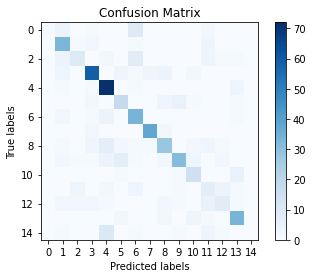

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
y_pred = model_tl.predict(feats_test)
cm = confusion_matrix(labels_test, y_pred)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(classes_labels)))
plt.show()


In [16]:
print(f"C = {c} : Accuracy = {model_tl.score(feats_test, labels_test)}")

C = 0.01 : Accuracy = 0.6660929432013769
